In [1]:
!pip3 install torch torchvision entmax

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


# Sparse Transformations

## Sparsemax

The **sparsemax transformation** corresponds to the following optimization problem:

$$
\mathrm{sparsemax}(z) = \arg\min_{p \in \triangle} \frac{1}{2}\|p - z\|^2
$$

It can be solved efficiently with the `sparsemax` algorithm.

In [2]:
# Simple example with sparsemax on 3 classes.
import torch
from torch.nn.functional import softmax
from entmax import sparsemax

scores = torch.tensor([-2.0, 0.0, 0.5])  # Set the logits.

probabilities = softmax(scores, dim=0)
print('Softmax probabilities:', probabilities)

probabilities = sparsemax(scores, dim=0)
print('Sparsemax probabilities:', probabilities)

Softmax probabilities: tensor([0.0486, 0.3592, 0.5922])
Sparsemax probabilities: tensor([0.0000, 0.2500, 0.7500])


In [3]:
# We can also compute gradients.
scores = torch.tensor([-2.0, 0.0, 0.5], requires_grad=True)
probabilities = sparsemax(scores, dim=0)
print('Sparsemax probabilities:', probabilities)

# Gradient of the probability of the last class with respect to scores.
probabilities[-1].backward()
print('Gradients:', scores.grad)

Sparsemax probabilities: tensor([0.0000, 0.2500, 0.7500], grad_fn=<SparsemaxFunctionBackward>)
Gradients: tensor([ 0.0000, -0.5000,  0.5000])


## $\alpha$-Entmax

The $\alpha$-entmax tranformation is more general than sparsemax. It has a parameter $\alpha>0$ and it corresponds to the following optimization problem:

$$
\alpha\text{-}\mathrm{entmax}(z) = \arg\min_{p \in \triangle} z^\top p - \Omega^T_\alpha(p),
$$
where $\Omega^T_\alpha: \triangle \rightarrow \mathbb{R}$ is a generalized negentropy, called **Tsallis $\alpha$-negentropy**:
$$
\Omega_p^T(p) = \left\{
\begin{array}{ll}
\frac{1}{\alpha(\alpha-1)} \left( \sum_i p_i^\alpha  - 1 \right) & \text{if $\alpha \ne 1$}\\
\sum_i p_i \log p_i & \text{if $\alpha = 1$}.
\end{array}  
\right.
$$

The entmax transformation can be computed for any $\alpha > 0$ with a general bisection algorithm, `entmax_bisect`.
It has the following properties:
- It can sparse if $\alpha>1$;  
- It recovers softmax if $\alpha=1$;  
- It recovers sparsemax if $\alpha=2$;  
- There is a faster algorithm for $\alpha=1.5$ (`entmax15`).  

In [4]:
# Simple example with entmax on 3 classes.
from entmax import entmax15, entmax_bisect

scores = torch.tensor([-2.0, 0.0, 0.5])  # Set the logits.

probabilities = entmax15(scores, dim=0)
print('Entmax probabilities (alpha = 1.5):', probabilities)

alphas = torch.linspace(0.1, 2, 20)
for alpha in alphas:
    probabilities = entmax_bisect(scores, alpha=alpha, dim=0)
    print('Entmax probabilities (alpha = %f):' % alpha, probabilities)

Entmax probabilities (alpha = 1.5): tensor([0.0000, 0.3260, 0.6740])
Entmax probabilities (alpha = 0.100000): tensor([0.1967, 0.3579, 0.4454])
Entmax probabilities (alpha = 0.200000): tensor([0.1842, 0.3587, 0.4571])
Entmax probabilities (alpha = 0.300000): tensor([0.1707, 0.3594, 0.4699])
Entmax probabilities (alpha = 0.400000): tensor([0.1562, 0.3600, 0.4838])
Entmax probabilities (alpha = 0.500000): tensor([0.1407, 0.3604, 0.4989])
Entmax probabilities (alpha = 0.600000): tensor([0.1241, 0.3606, 0.5152])
Entmax probabilities (alpha = 0.700000): tensor([0.1065, 0.3607, 0.5328])
Entmax probabilities (alpha = 0.800000): tensor([0.0879, 0.3605, 0.5516])
Entmax probabilities (alpha = 0.900000): tensor([0.0685, 0.3601, 0.5715])
Entmax probabilities (alpha = 1.000000): tensor([0.3333, 0.3333, 0.3333])
Entmax probabilities (alpha = 1.100000): tensor([0.0292, 0.3576, 0.6132])
Entmax probabilities (alpha = 1.200000): tensor([0.0120, 0.3546, 0.6334])
Entmax probabilities (alpha = 1.300000): te

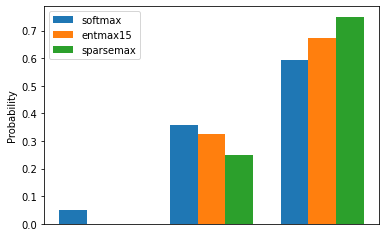

In [5]:
# Visualize softmax, sparsemax, entmax as bar plots.
import numpy as np
import matplotlib.pyplot as plt

classes = ("1", "2", "3")
probabilities = {
    'softmax': softmax(scores, dim=0),
    'entmax15': entmax15(scores, dim=0),
    'sparsemax': sparsemax(scores, dim=0),
}

x = np.arange(len(classes))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for name, values in probabilities.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=name)
    multiplier += 1

ax.set_ylabel('Probability')
ax.get_xaxis().set_visible(False)
ax.legend(loc='upper left')
plt.show()

## $\alpha$-Normmax

The $\alpha$-normmax tranformation also has a parameter $\alpha>1$ and it corresponds to the following optimization problem:

$$
\alpha\text{-}\mathrm{normmax}(z) = \arg\min_{p \in \triangle} z^\top p - \Omega^N_\alpha(p),
$$
where $\Omega^N_\alpha: \triangle \rightarrow \mathbb{R}$ is another generalized negentropy, called **norm $\alpha$-negentropy**:
$$
\Omega_p^N(p) = \|p\|_\alpha  - 1 = \left( \sum_i p_i^\alpha \right)^{1/\alpha} - 1.
$$

The normmax transformation can be computed for any $\alpha > 1$ with a general bisection algorithm, `normmax_bisect`.
It has the following properties:
- It can sparse for any $\alpha>1$;  
- As $\alpha \rightarrow \infty$, it tends to assign uniform probability to the selected classes.  

In [6]:
# Simple example with normmax on 3 classes.
from entmax import normmax_bisect

alpha=10000  # close to infinity.
probabilities = normmax_bisect(scores, alpha=alpha, dim=0)
print('Normmax probabilities (alpha = %f):' % alpha, probabilities)

alphas = np.linspace(1, 5.5, 10)
for alpha in alphas:
    probabilities = normmax_bisect(scores, alpha=alpha, dim=0)
    print('Normmax probabilities (alpha = %f):' % alpha, probabilities)

Normmax probabilities (alpha = 10000.000000): tensor([0.0000, 0.5000, 0.5000])
Normmax probabilities (alpha = 1.000000): tensor([0., 0., 1.])
Normmax probabilities (alpha = 1.500000): tensor([0.0000, 0.1885, 0.8115])
Normmax probabilities (alpha = 2.000000): tensor([0.0000, 0.3110, 0.6890])
Normmax probabilities (alpha = 2.500000): tensor([0.0000, 0.3629, 0.6371])
Normmax probabilities (alpha = 3.000000): tensor([0.0000, 0.3917, 0.6083])
Normmax probabilities (alpha = 3.500000): tensor([0.0000, 0.4102, 0.5898])
Normmax probabilities (alpha = 4.000000): tensor([0.0000, 0.4232, 0.5768])
Normmax probabilities (alpha = 4.500000): tensor([0.0000, 0.4328, 0.5672])
Normmax probabilities (alpha = 5.000000): tensor([0.0000, 0.4403, 0.5597])
Normmax probabilities (alpha = 5.500000): tensor([0.0000, 0.4462, 0.5538])


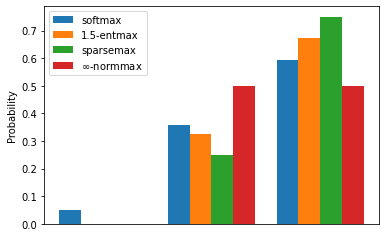

In [7]:
# Visualize softmax, sparsemax, entmax, normmax as bar plots.
classes = ("1", "2", "3")
probabilities = {
    'softmax': softmax(scores, dim=0),
    '1.5-entmax': entmax15(scores, dim=0),
    'sparsemax': sparsemax(scores, dim=0),
    '$\\infty$-normmax': normmax_bisect(scores, alpha=10000, dim=0),
}

x = np.arange(len(classes))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for name, values in probabilities.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=name)
    multiplier += 1

ax.set_ylabel('Probability')
ax.get_xaxis().set_visible(False)
ax.legend(loc='upper left')
plt.show()

## SparseMAP ($k$-subsets)

**SparseMAP** is the generalization of sparsemax for structures. It optimizes over a polytope $\mathrm{conv}(Y)$ instead of the probability simplex $\triangle$.

$$
\mathrm{SparseMAP}(z; Y) = \arg\min_{y \in \mathrm{conv}(Y)} \|y - z\|^2
$$

We consider the **$k$-subsets** problem, where $Y$ is the set of all vectors with $k$ entries equal to 1, all other entries zero. We can think of $k$ as a budget.

Some properties:  
- $k$-subsets recovers sparsemax if $k=1$.  
- The forward pass can be computed efficiently with a bisection algorithm (`budget_bisect`).

In [8]:
# Simple example with k-subsets on 3 classes.
from entmax import budget_bisect

scores = torch.tensor([-2.0, 0.0, 0.5])
probabilities = sparsemax(scores, dim=0)
print('Sparsemax probabilities:', probabilities)

for k in [1, 2, 3]:
    probabilities = budget_bisect(scores, budget=k, dim=0)
    print('k-subsets probabilities (k = %d):' % k, probabilities)

Sparsemax probabilities: tensor([0.0000, 0.2500, 0.7500])
k-subsets probabilities (k = 1): tensor([0.0000, 0.2500, 0.7500])
k-subsets probabilities (k = 2): tensor([0.0000, 1.0000, 1.0000])
k-subsets probabilities (k = 3): tensor([1., 1., 1.])


## Temperature and regularization path

All the transformations above can be used with a temperature parameter $\beta^{-1}$, which means multiplying the scores $z$ by $\beta$ before applying the transformation.

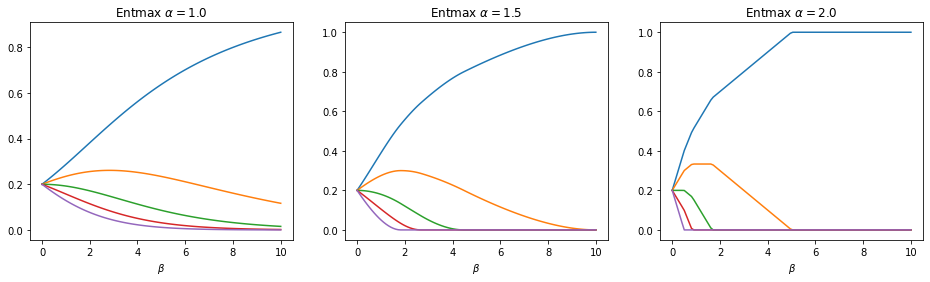

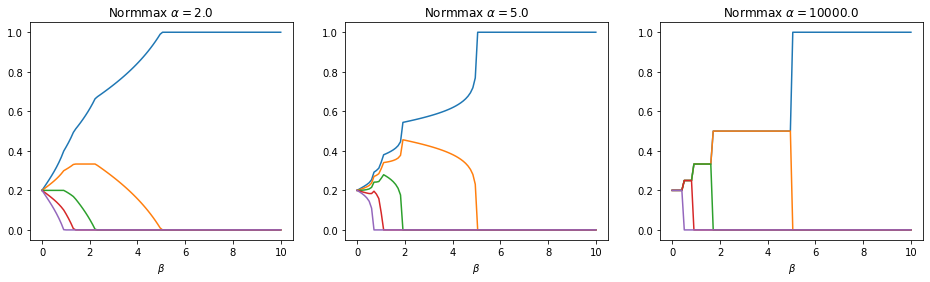

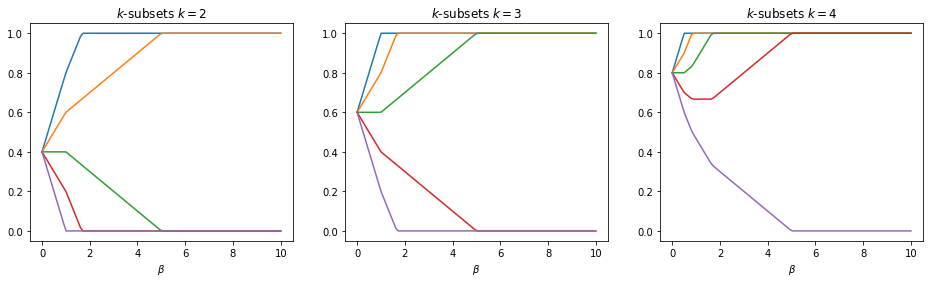

In [9]:
# (Inverse) temperature parameter.
betas = torch.linspace(0, 10, 100)

# Define scores over 5 classes.
scores = torch.tensor([2.0, 1.8, 1.6, 1.4, 1.2])

# Start with entmax.
alphas = [1.001, 1.5, 2.]

fig, ax = plt.subplots(1, len(alphas), figsize=(16, 4))

for j, alpha in enumerate(alphas):
    probabilities = entmax_bisect(
        betas.unsqueeze(1) * scores.unsqueeze(0),
        alpha=alpha,
        dim=1)

    for i in range(scores.shape[0]):
        ax[j].plot(betas, probabilities[:, i])
        ax[j].set_title('Entmax $\\alpha=%.1f$' % alpha)
        ax[j].set_xlabel('$\\beta$')

plt.show()

# Same with normmax.
alphas = [2, 5, 10000.]

fig, ax = plt.subplots(1, len(alphas), figsize=(16, 4))

for j, alpha in enumerate(alphas):
    probabilities = normmax_bisect(
        betas.unsqueeze(1) * scores.unsqueeze(0),
        alpha=alpha, dim=1)

    for i in range(scores.shape[0]):
        ax[j].plot(betas, probabilities[:, i])
    ax[j].set_title('Normmax $\\alpha=%.1f$' % alpha)
    ax[j].set_xlabel('$\\beta$')

plt.show()

# Same with k-subsets.
budgets = [2, 3, 4]

fig, ax = plt.subplots(1, len(alphas), figsize=(16, 4))

for j, k in enumerate(budgets):
    probabilities = budget_bisect(
        betas.unsqueeze(1) * scores.unsqueeze(0),
        budget=k,
        dim=1)

    for i in range(scores.shape[0]):
        ax[j].plot(betas, probabilities[:, i])
    ax[j].set_title('$k$-subsets $k=%d$' % k)
    ax[j].set_xlabel('$\\beta$')

plt.show()

# Fenchel-Young Losses


Fenchel-Young losses are defined using a generalized negentropy function $\Omega : \triangle \rightarrow \mathbb{R}$ as:

$$
L_\Omega(z; p) = \Omega(p) + \Omega^*(z) - z^\top p,
$$

where $\Omega^*(z)$ is the convex conjugate of $\Omega(p)$:

$$
\Omega^*(z) = \max_{p\in \triangle} z^\top p - \Omega(p).
$$

For example, if $\Omega(p) = \sum_i p_i \log p_i$ is the Shannon negentropy, $\Omega^*(z) = \log \sum_i \exp(z_i)$ is the log-sum-exp function, and $L_\Omega(z; p) = \mathrm{KL}(p \| \mathrm{softmax}(z))$ corresponds to the cross-entropy.

Therefore, **Fenchel-Young losses generalize the cross-entropy loss.** They are particularly convenient for handling transformations induced by generalized entropies (such as Tsallis and norm entropies). The corresponding loss functions are `EntmaxBisectLoss` and `NormmaxBisectLoss`.

In [10]:
# Define negentropy functions.
def tsallis_negentropy(p, alpha):
    if alpha == 1:
        return torch.sum(p * torch.log(p))
    else:
        return (torch.sum(p**alpha) - 1) / (alpha - 1)

def norm_negentropy(p, alpha):
    return torch.norm(p, p=alpha) - 1

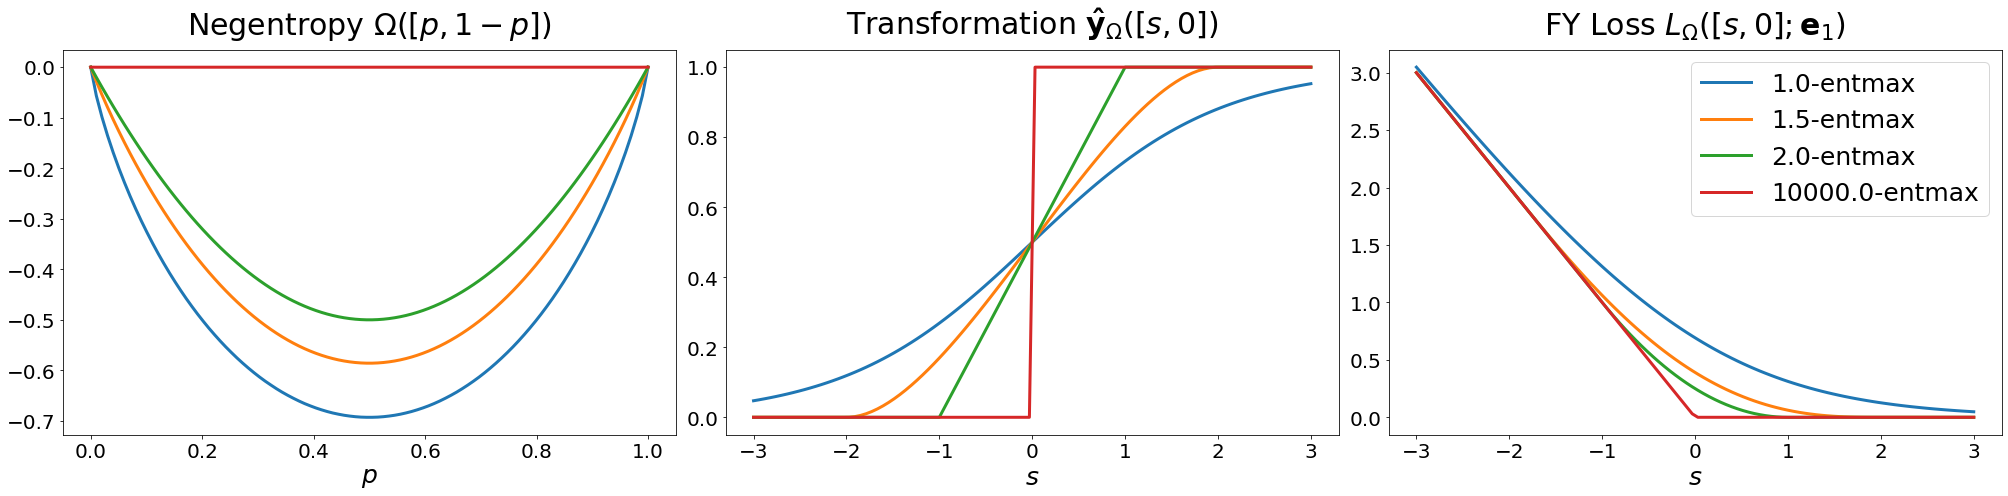

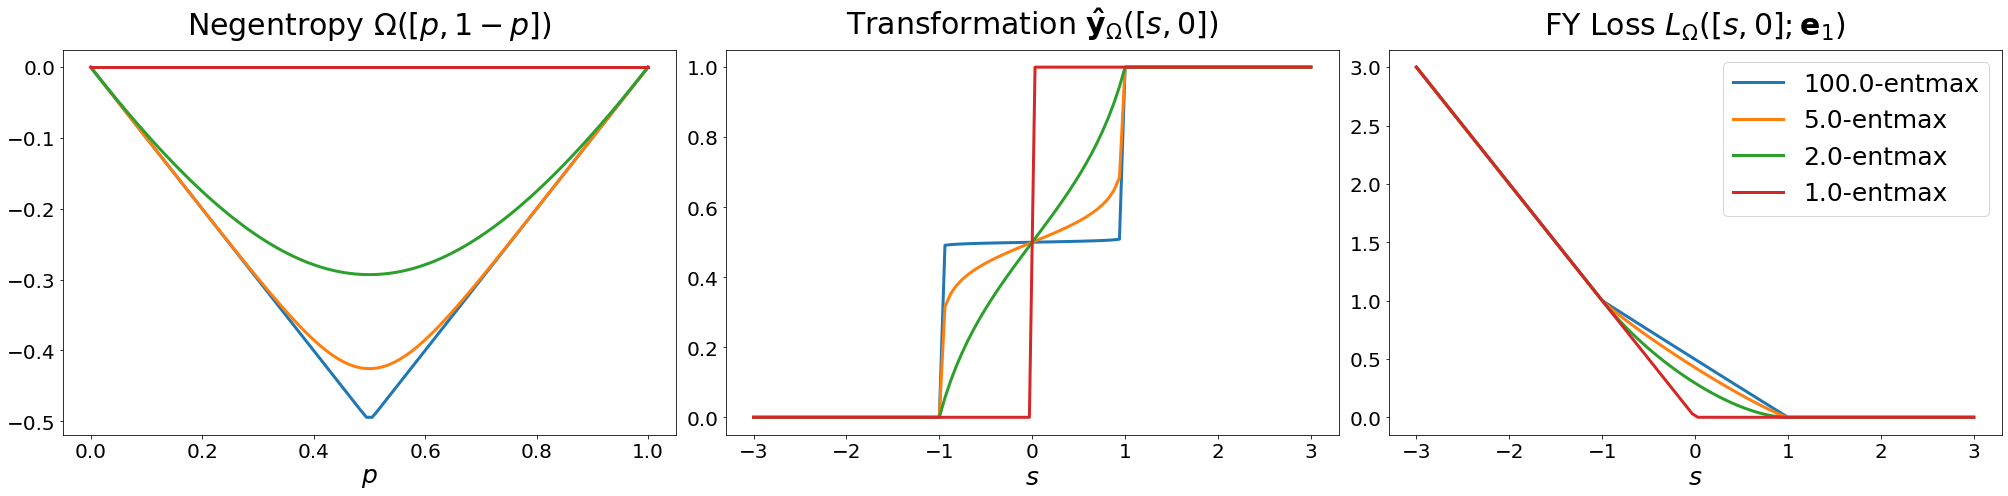

In [11]:
from entmax import (sparsemax, entmax15, entmax_bisect,
                    EntmaxBisectLoss, NormmaxBisectLoss, normmax_bisect)

probabilities = torch.linspace(0, 1, 100)
scores = torch.linspace(-3, 3, 100)

# We will plot the negentropy functions, the corresponding transformations,
# and the loss for simple problems with two classes.
fig, axes = plt.subplots(1, 3, figsize=(28, 7))

# Tsallis entropies and entmax.
alphas = [1.001, 1.5, 2., 1e4]
for alpha in alphas:
    negentropy = [tsallis_negentropy(torch.tensor([p, 1-p]), alpha=alpha) for p in probabilities]
    yhat = [entmax_bisect(torch.tensor([s, 0]), alpha=alpha) for s in scores]
    fy_loss = [EntmaxBisectLoss(alpha=alpha)(torch.tensor([[s, 0]]), torch.tensor([0])) for s in scores]

    # Plot for Tsallis negentropy.
    axes[0].plot(probabilities, negentropy, label='%.1f-entmax' % alpha, linewidth=3)

    # Plot for entmax transformation.
    axes[1].plot(scores, [y[0] for y in yhat], label='%.1f-entmax' % alpha, linewidth=3)

    # Plot for FY Loss (Tsallis).
    axes[2].plot(scores, fy_loss, label='%.1f-entmax' % alpha, linewidth=3)

axes[0].set_title('Negentropy $\Omega([p, 1-p])$', fontsize=30, pad=15)
axes[0].set_xlabel('$p$', fontsize=25)
axes[0].tick_params(axis='x', labelsize=20, which='major')
axes[0].tick_params(axis='y', labelsize=20, which='major')
axes[1].set_title('Transformation $\mathbf{\hat{y}}_\Omega([s, 0])$', fontsize=30, pad=15)
axes[1].set_xlabel('$s$', fontsize=25)
axes[1].tick_params(axis='x', labelsize=20, which='major')
axes[1].tick_params(axis='y', labelsize=20, which='major')
axes[2].set_title('FY Loss $L_\Omega([s, 0]; \mathbf{e}_1)$', fontsize=30, pad=15)
axes[2].set_xlabel('$s$', fontsize=25)
axes[2].tick_params(axis='x', labelsize=20, which='major')
axes[2].tick_params(axis='y', labelsize=20, which='major')

legend = axes[2].legend(fontsize=25)
plt.setp(legend.get_title(), fontsize=27)

plt.tight_layout()
plt.show()


# Plotting
fig, axes = plt.subplots(1, 3, figsize=(28, 7))

# Norm entropies and normmax.
alphas = [100, 5., 2., 1.]
for alpha in alphas:
    negentropy = [norm_negentropy(torch.tensor([p, 1-p]), alpha=alpha) for p in probabilities]
    yhat = [normmax_bisect(torch.tensor([s, 0]), alpha=alpha) for s in scores]
    fy_loss = [NormmaxBisectLoss(alpha=alpha)(torch.tensor([[s, 0]]), torch.tensor([0])) for s in scores]

    # Plot for Tsallis negentropy.
    axes[0].plot(probabilities, negentropy, label='%.1f-normmax' % alpha, linewidth=3)

    # Plot for entmax transformation.
    axes[1].plot(scores, [y[0] for y in yhat], label='%.1f-normmax' % alpha, linewidth=3)

    # Plot for FY Loss (Tsallis).
    axes[2].plot(scores, fy_loss, label='%.1f-entmax' % alpha, linewidth=3)

axes[0].set_title('Negentropy $\Omega([p, 1-p])$', fontsize=30, pad=15)
axes[0].set_xlabel('$p$', fontsize=25)
axes[0].tick_params(axis='x', labelsize=20, which='major')
axes[0].tick_params(axis='y', labelsize=20, which='major')
axes[1].set_title('Transformation $\mathbf{\hat{y}}_\Omega([s, 0])$', fontsize=30, pad=15)
axes[1].set_xlabel('$s$', fontsize=25)
axes[1].tick_params(axis='x', labelsize=20, which='major')
axes[1].tick_params(axis='y', labelsize=20, which='major')
axes[2].set_title('FY Loss $L_\Omega([s, 0]; \mathbf{e}_1)$', fontsize=30, pad=15)
axes[2].set_xlabel('$s$', fontsize=25)
axes[2].tick_params(axis='x', labelsize=20, which='major')
axes[2].tick_params(axis='y', labelsize=20, which='major')

legend = axes[2].legend(fontsize=25)
plt.setp(legend.get_title(), fontsize=27)

plt.tight_layout()
plt.show()